# Thermoelasticity-based modal damage identification

## Import packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pysfmov as sfmov
#import km
import FLife 

## Input parameters

### Thermal video

In [ ]:
k = 6.51 # slope endurance curve
bas = -1/k
B = 800.26
C = B**k  # s = B * N**bas or s^k * N = C

In [3]:
filename = './data/rec0.sfmov'
fs = 400
dt = 1 / fs

data = sfmov.get_data(filename)
km = 1/ (6 * 2 * 10**(-9)) * 10**-6 # stress amplitude in MPa  # Calibration Factor [Pa^-1]
stress = data * km

location = 38, 78, 5, 5 #vert mode area
interval = [53, 57] # HZ
df_fft = 0.1

### Material

In [4]:
k = 6.51 # slope endurance curve
B = 800.26 # endurance curve 
C = B**k

In [5]:
td = ThermalData(stress, dt)

In [35]:
life = td.get_life(C, k, 'Modal', interval = interval, location = location)

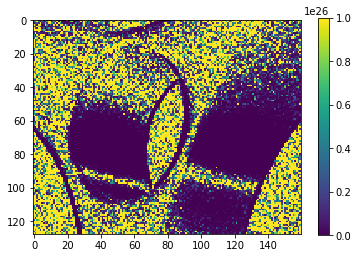

In [34]:
%matplotlib inline
plt.figure()
plt.imshow(life)
plt.colorbar()
plt.clim(0.9*1e10,1e26)

## Computation

In [36]:
class ThermalData():
    
    
    def __init__(self, x, dt):
        
        self.x = x
        self.dt = dt
    
    def get_life(self, C, k, method = None, interval = None, location = None, f_step = 0.1):
        
        N = self.x.shape[0]
        dt = 1 / fs
        ds = self.x - self.x[0,:,:]
        
        life = np.zeros(shape=(ds.shape[1], ds.shape[2]))
        
        if location is not None:
            (x,y,w,h) = location    
            ds = ds[:, y:(y+h), x:(x+w)]
        
        if method == 'Modal':
            
            if interval == None:
                raise ValueError('Frequency interval must be defined')

            fft  = np.abs(np.fft.rfft(ds, N, axis=0) * 2 / N)
            freq = np.fft.rfftfreq(N, 1/fs)
        
            y_peak = np.max(fft[(freq > interval[0]) & (freq < interval[1])])
            x_peak = freq[np.where(fft == y_peak)[0][0]]
        
            amplitude = np.mean(fft[(freq >= x_peak - f_step) & (freq <= x_peak + f_step)], axis = 0)
            
            damage =  x_peak / (C / amplitude**k) 
            
            life = 1 / damage
        
        
        elif method == 'TovoBenasciutti':
            
            for i in range(ds.shape[1]):
                for j in range(ds.shape[2]):
                    td = FLife.SpectralData(ds[:,i,j], self.dt)
                    tb = FLife.TovoBenasciutti(td)
                    life[i,j] = tb.get_life(C = C, k = k, method = "method 2")
                    
        elif method == 'Dirlik':
            
            for i in range(ds.shape[1]):
                for j in range(ds.shape[2]):
                    td = FLife.SpectralData(ds[:,i,j], self.dt)
                    dirlik = FLife.Dirlik(td)
                    life[i,j] = dirlik.get_life(C = C, k = k)
                    
        elif method == 'Rainflow':
            
            for i in range(ds.shape[1]):
                for j in range(ds.shape[2]):
                    td= FLife.SpectralData(ds[:,i,j], self.dt)
                    rf= FLife.Rainflow(td)
                    life[i,j] = rf.get_life(C = C, k = k)                  

        if location is not None:
            return np.mean(life, axis = (0,1))
        else:
            return life

In [11]:
my_list = list(range(100000000))
with tqdm(total=len(my_list)) as pbar:
    for x in my_list:
        pbar.update(1)

100%|███████████████████████████████████████████████████████████████| 100000000/100000000 [00:39<00:00, 2519646.91it/s]
